## **Conexión MySQL y Python para obtener la información**
Realitza la connexió en Python amb el MySQL Workbench per a carregar tota la informació que tens en les taules.

#### **Importar librerias**

Para conectar la base de datos, necesitarè instalar el conector de mysql en python. Esto lo hago mediante el comando 'pip install mysql.connector' desde la consola de powershell.
Asi mis mismo iré instalando las librerias para visualización a lo largo del sprint.

In [9]:
# IMPORTAR LAS LIBRERIAS NECESARIAS
import mysql.connector
import pandas as pd
from datetime import datetime
from tabulate import tabulate
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr # lo utilizaré para establecer si existe relacion en alguna variable

#### **Crear conexión y obtener las tablas**

- Para conectar python con MySQL debo establercer la conexión a partir del conector instalado y entregando las credeciales de acceso a la base de datos.
- La base de datos que utilizaré se llama 'trades4' y eso me dará acceso a cada una de las dataframes.
- El siguiente paso es obtener las tablas para obtener los dataframes. 
- a cada tabla la llamaré 'df_{Nombre_de_tabla}

In [10]:
# CREO UNA CONEXIÓN PARA LA BASE DE DATOS 'TRADES4'
cnx = mysql.connector.connect(
    user='root',
    password='250301',
    host='localhost',
    database='trades4')
cursor = cnx.cursor()

# Obtener nombres de las tablas y las almaceno en una lista
cursor.execute("SHOW TABLES")
table_names = [table_name for (table_name,) in cursor.fetchall()] # display(table_names)
print(table_names)
# Obtener DataFrames de las tablas
dfs = {}
for table_name in table_names:
    cursor.execute(f"SELECT * FROM {table_name}")
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    dfs[table_name] = df

# Crear variables globales para cada DataFrame
for table_name, df in dfs.items():
    globals()[f"df_{table_name}"] = df

# Cerrar cursor y conexión
cursor.close()
cnx.close()

['card_status', 'companies', 'credit_cards', 'product_tx', 'products', 'transactions', 'users']


In [11]:
df_products.dtypes


id              object
product_name    object
price           object
colour          object
weight          object
warehouse_id    object
dtype: object

## **Ejercicio 1: Mostrar una variable numérica**

#### **Situación de trabajo** 
La empresa desea verificar y describir las edades de los usuarios, estableciendo variables numéricas para analizarlas al máximo. Esto es necesario para desarrollar una estrategia que permita mejorar los productos y plataformas dirigidos a esta demografía.

#### **Desarrollo:** 

**Primer paso:**        
De la tabla `df_users` obtendré la información de la fecha de nacimiento y con ello calcularé la edad de cada usuario.

In [12]:
# FUNCIÓN PARA CONVERTIR 'BIRTH_DATE' A FORMATO DE FECHA Y CALCULAR LA EDAD EN AÑOS
df_users['birth_date'] = pd.to_datetime(df_users['birth_date'], format='%b %d, %Y')
df_users['age'] = datetime.now().year - df_users['birth_date'].dt.year

**Segundo paso:**       
A partir de la edad realizaré un boxplot graficando la mediana, percentil 25 y 75

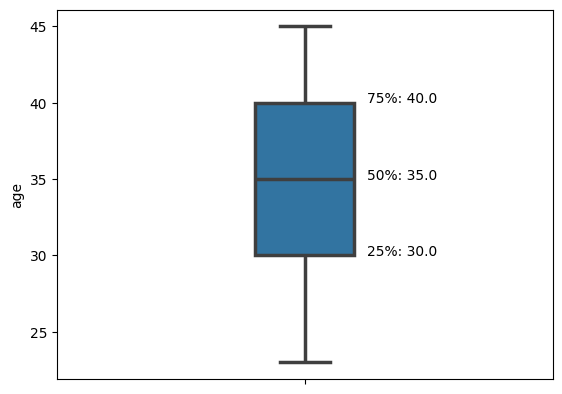

In [13]:
sns.boxplot(y=df_users["age"], width=0.2, fliersize=5, linewidth=2.5) 
# Calcular los cuartiles y estadigrafos
quartiles = df_users["age"].quantile([0.25, 0.5, 0.75])

# Añadir los textos de los cuartiles
for q, value in quartiles.items():
    label = f'{int(q * 100)}%: {value:.1f}'
    plt.text(0.125, value, label, ha='left')

# Ejercicio 2: Dos variables numéricas

#### **Situación:**

La empresa ha pedido complementar la informacion anterior solicitado un análisis para determinar la relación entre la edad de los usuarios y su capacidad de compra, representada por la cantidad de dinero que gastan. 

Para llevar a cabo este análisis, es necesario seleccionar dos variables numéricas: la edad de los usuarios y el monto de las compras, que se extraerá de la tabla transactions. El objetivo es identificar patrones y tendencias que puedan informar futuras estrategias de marketing y ventas.

#### **Desarrollo**

**Utilizar Tablas df_users y df_transactions:**     
Utilizaré tanto la tabla `df_users` como la tabla `df_transactions` para obtener la información necesaria.

**Calcular la Edad de los Usuarios:**          
La edad ya esta calculada en el ejercicio anterior

**Transformación de datos**     
Para que las graficas se puedan realizar, debo asegurar que los valores son compatibles. Para ello:

In [14]:
# COMO ES UN 'OBJECT' HAGO LA CONVERSIÓN A 'FLOAT' PARA OBTENER LAS METRICAS:
df_transactions['amount'] = df_transactions['amount'].astype(float)

**Unir Tablas por Identificador de Usuario:**            
Para unirlas usando 'panda' debo cambiar el nombre de df_users["id"] a df_users["user_id"] para que se puedan unir a través de esta columna.

In [15]:
df_users = df_users.rename(columns={"id": "user_id"})

Uniré las tablas `df_users` y `df_transactions` utilizando los identificadores de usuario (`user_id`).

In [16]:
df_user_tx = pd.merge(df_users, df_transactions, on="user_id")

**Relacionar promedio de comprar por edad**         
obtengo el promedio de compra agrupado por edad a traves de:

In [17]:
compra_by_age = df_user_tx.groupby('age')["amount"].mean().reset_index()
global_average = df_user_tx["amount"].mean()# Calcular correlación de Pearson entre edad y promedio de compra
correlation = compra_by_age['age'].corr(compra_by_age['amount'])

**Visualizar Relación con Scatter Plot:**       
Visualizaré la relación entre la edad y la capacidad de compra mediante un diagrama de dispersión (scatter plot).


Text(0.05, 0.95, 'Correlación de Pearson: -0.05')

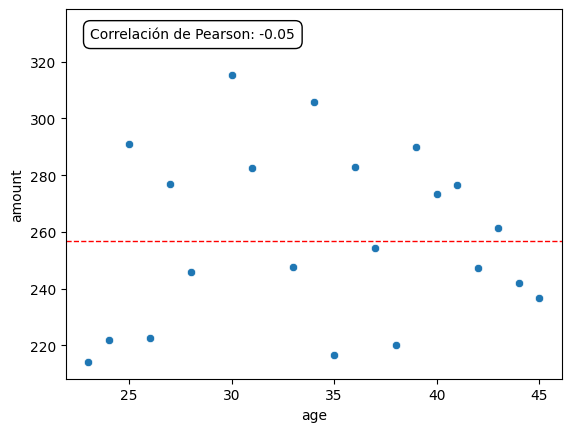

In [18]:
sns.scatterplot(data=compra_by_age, x="age", y="amount")
plt.axhline(y=global_average, color='red', linestyle='--', linewidth=1, label=f'Promedio Global: {global_average:.2f}€')
plt.text(0.05, 0.95, f'Correlación de Pearson: {correlation:.2f}', transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))

# Ejercicio 3: Una variable categórica.

#### **Situación:**

- Con el objetivo de investigar las compras perdidas y determinar la necesidad de desarrollar nuevas estrategias, se solicita una variable categórica que permita identificar estos casos. He seleccionado la variable "declined" ya que indica si las transacciones han sido rechazadas, lo cual permite evaluar si es necesario profundizar en este aspecto.

#### **Desarrollo:**

**Genero grafico countplot para describir las transacciones declinadas según count:**

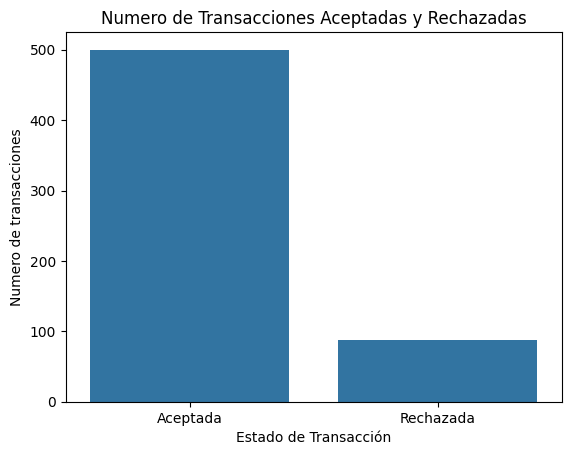

In [19]:
# Crear el gráfico de barras
sns.countplot(x='declined', data=df_transactions)
plt.xticks(ticks=[0, 1], labels=['Aceptada', 'Rechazada'])
plt.title('Numero de Transacciones Aceptadas y Rechazadas')
plt.xlabel('Estado de Transacción')
plt.ylabel('Numero de transacciones')
plt.show()

# Ejercicio 4: Una variable categórica y una numérica.

####  **Situación:**

La empresa ha solicitado realizar un análisis detallado de los montos asociados a transacciones declinadas y no declinadas. El objetivo es identificar patrones y diferencias significativas entre estos dos grupos, lo cual será fundamental para optimizar estrategias empresariales relacionadas con la gestión de transacciones y la mejora de la experiencia del cliente.

#### **Desarrollo:**

Para obtener la visualización sigo los siguientes pasos:

1. **Selección de Variables:**
   Tomo las variables de 'declined' como categórica y 'amount' como continua.

2. **Gráfico de Barras:**
   Realizo un gráfico de barras que muestra la frecuencia de transacciones aceptadas y rechazadas.

3. **Boxplot:**
   Utilizo un boxplot para mostrar la distribución de los montos ('amount') para transacciones aceptadas y rechazadas.


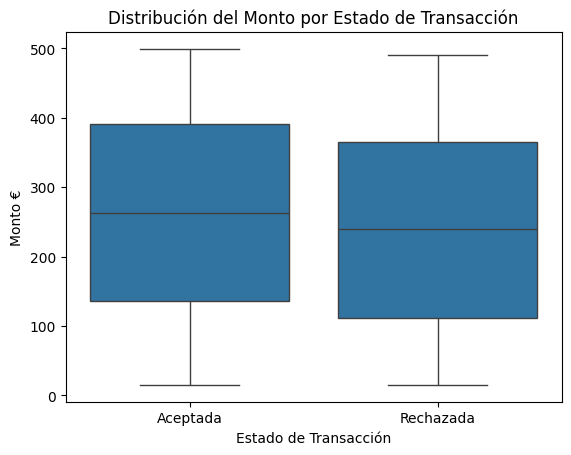

In [20]:
# Gráfico de caja de la variable numérica 'amount' por la categórica 'declined'

sns.boxplot(x='declined', y='amount', data=df_transactions)
plt.title('Distribución del Monto por Estado de Transacción')
plt.xlabel('Estado de Transacción')
plt.ylabel('Monto €')
plt.xticks(ticks=[0, 1], labels=['Aceptada', 'Rechazada'])
plt.show()


# Ejercicio 5: Dos variables categóricas.

#### **Situación:**

La empresa desea identificar la relación entre el pais de origen del usuario y el estado de las transacciones para optimizar sus esfuerzos y evitar pérdidas financieras.


#### **Desarrollo:**

Para abordar esta situación, se llevará a cabo el siguiente análisis:

1. **Unión de Tablas:**
   - Se unirá la tabla `df_transactions` con la tabla `df_users` utilizando la columna `user_id`. Esta unión permitirá enriquecer los datos de transacciones con información adicional de los usuarios, como el país de origen.
2. **Definir las Variables Categóricas:**
   - Me aseguro que se reconocerà como variable categorica. Esto facilitará el análisis y la visualización de los datos. 
3. **Análisis de Relación País - Estado de Transacciones:**
   - Se explorará cómo varía el estado de las transacciones (aceptadas o rechazadas) en diferentes países.
   - Esto permitirá identificar patrones y tendencias que puedan indicar áreas geográficas con mayores incidencias de transacciones rechazadas.

Este enfoque permitirá a la empresa tomar decisiones informadas y estratégicas para optimizar sus operaciones globales y reducir las pérdidas asociadas con transacciones rechazadas.



In [21]:
df_user_tx["declined"] = df_user_tx["declined"].astype('category')
df_user_tx["country"] = df_user_tx["country"].astype('category')

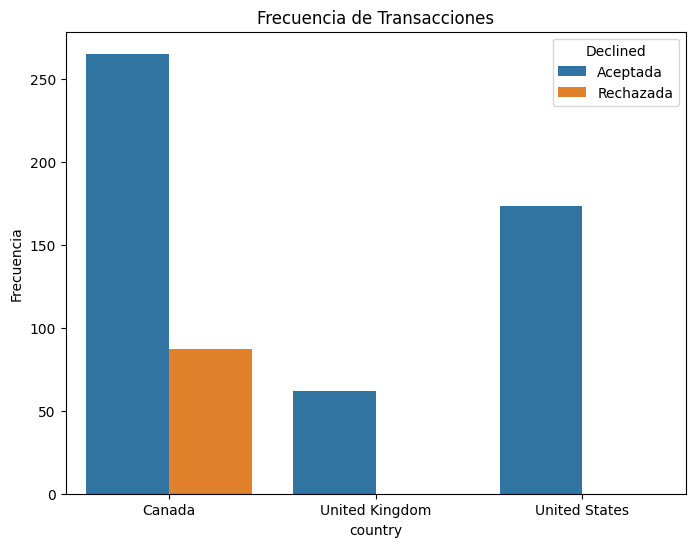

In [22]:

# Graficar los datos
plt.figure(figsize=(8, 6))

# Gráfico de conteo para las variables categóricas 'declined' y 'country'
sns.countplot(x='country', hue='declined', data=df_user_tx)
plt.title('Frecuencia de Transacciones')
plt.ylabel('Frecuencia')
plt.legend(title='Declined', labels=['Aceptada', 'Rechazada'])
plt.show()

# Ejercicio 6: Tres variables.

#### **Situacion:**

Como complemento al ejercicio anterior, la empresa solicita un análisis adicional que ofrezca más detalles sobre las transacciones aceptadas y rechazadas. Para ello, he decidido estudiar tres variables: el estado de las transacciones, el país de las compañias y el monto asociado a cada transacción. Al investigar estas variables, espero identificar patrones que puedan ayudar a mejorar el rendimiento de la empresa y optimizar sus procesos de transacción.

#### **Desarrollo:**

Este análisis utiliza tres variables clave: `declined` y `country` (categóricas) para distinguir el estado de las transacciones y su origen geográfico, y `amount` (numérica) para el valor de las transacciones.

1. Unimos `df_transactions` con `df_users` usando `user_id`.
2. Luego unimos el resultado con `df_companies` usando `business_id`.
3. Convertimos `declined` y `country` en variables categóricas.

Finalmente, creamos un gráfico de barras que muestra el monto total de las transacciones agrupadas por país y estado de transacción (aceptada o rechazada). Este gráfico identifica patrones y diferencias en el comportamiento de las transacciones, proporcionando información valiosa para mejorar las estrategias y operaciones de la empresa.


In [23]:
df_user_tx = df_user_tx.rename(columns={"id": "id_tx"})
df_transactions=df_transactions.rename(columns={"business_id": "company_id"})

In [24]:
df_company_tx = pd.merge(df_companies, df_transactions, on="company_id")

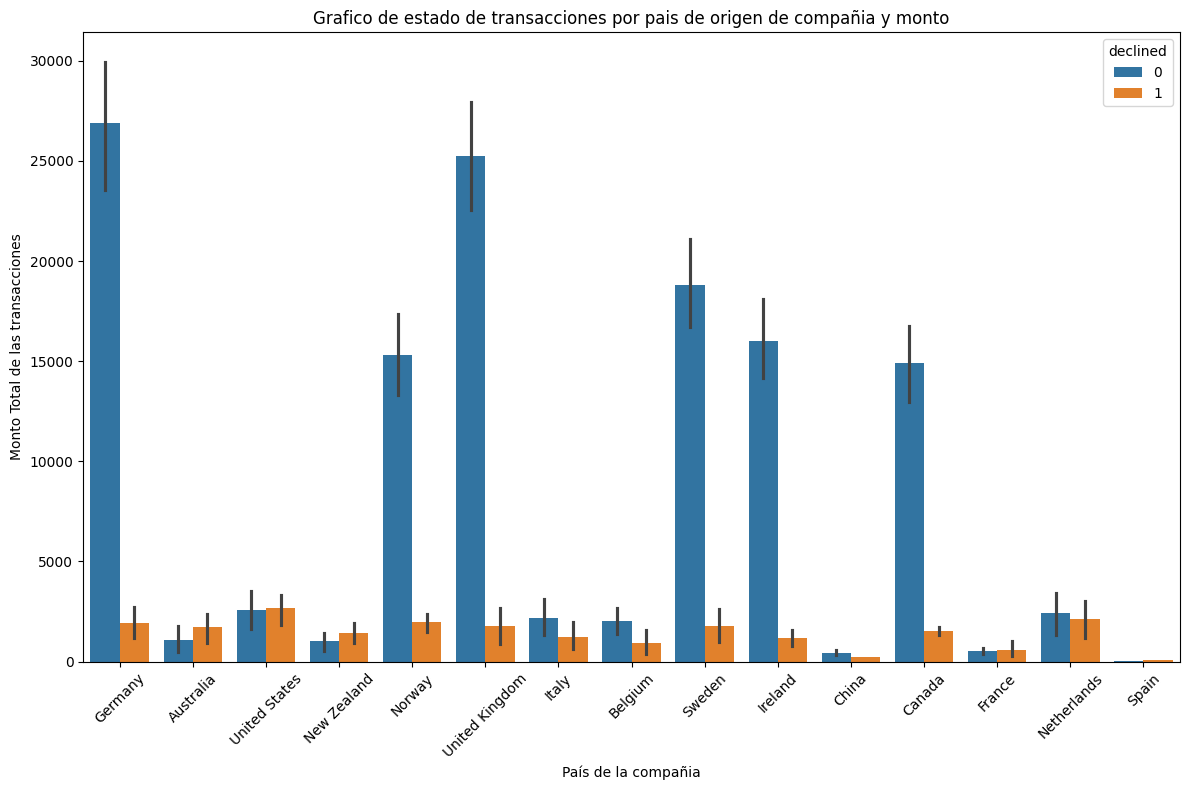

In [25]:


# Gráfico de barras agrupadas con 'amount' por 'country' y 'declined'
plt.figure(figsize=(12, 8))
sns.barplot(x='country', y='amount', hue='declined', data=df_company_tx, estimator=sum)
plt.title('Grafico de estado de transacciones por pais de origen de compañia y monto')
plt.xlabel('País de la compañia')
plt.ylabel('Monto Total de las transacciones')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Ejercicio 7: Graficar un pairplot

#### **Situacion:**

La empresa ha solicitado un análisis detallado que muestre todas las relaciones posibles entre las variables numéricas en las transacciones, con el objetivo de identificar correlaciones y patrones que puedan mejorar la comprensión del comportamiento del usuario y optimizar los procesos de transacción.

Para este análisis, se han seleccionado las variables `amount` (monto de la transacción), `age_group` (grupo de edad del usuario) y `declined` (estado de la transacción). 

El pairplot mostrará todas las relaciones posibles entre las variables numéricas, ayudando a identificar correlaciones y patrones entre las variables transaccionales.

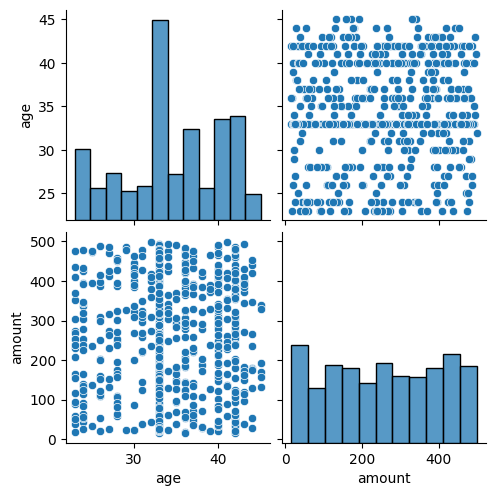

In [26]:
sns.pairplot(df_user_tx)
plt.show()